In [1]:
#
# Weakly supervised learning,
# CNN-GlobalAveragePooling MYIMG
#
# @author becxer
# @email becxer87@gmail.com
# @reference https://github.com/sjchoi86/Tensorflow-101
#

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline  

print ("packages are loaded")

packages are loaded


In [2]:
# Load npz data
npz_path = "images/MYIMG/my_img.npz"

load_data = np.load(npz_path)
print ("Load data : " + str(load_data.files))

train_img = load_data['train_img']
train_label = load_data['train_label']
valid_img = load_data['valid_img']
valid_label = load_data['valid_label']
test_img = load_data['test_img']
test_label = load_data['test_label']

print ("train_img shape : "  + str(train_img.shape))
print ("valid_img shape : "  + str(valid_img.shape))
print ("test_img shape : "  + str(test_img.shape))

Load data : ['valid_img', 'train_img', 'test_img', 'train_label', 'test_label', 'valid_label']
train_img shape : (876, 4096)
valid_img shape : (109, 4096)
test_img shape : (111, 4096)


In [25]:
# Options for training
learning_rate = 0.01
training_epochs = 1000
batch_size = 100
display_step = 50

# Deviation of weights
w_dev = 0.1

# Options for dropout
drop_out_ratio = 0.7

In [6]:
# Build CNN-GlobalAveragePooling graph

WS = {
    'wc_1' : tf.Variable(tf.random_normal([3,3,1,64], stddev=w_dev)),
    'wc_2' : tf.Variable(tf.random_normal([3,3,64,128], stddev=w_dev)),
    'out'  : tf.Variable(tf.random_normal([128,3],stddev=w_dev))
}

BS = {
    'bc_1' : tf.Variable(tf.random_normal([64], stddev=w_dev)),
    'bc_2' : tf.Variable(tf.random_normal([128], stddev=w_dev)),
    'out' : tf.Variable(tf.random_normal([3], stddev=w_dev))
}

def CNN_GAP(_X,  _W, _B, _dop):
    _X = tf.reshape(_X, [-1,64,64,1])
    
    _conv1 = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(_X,_W['wc_1'], strides=[1,1,1,1], padding="SAME"),_B['bc_1']))
    _max_pool1 = tf.nn.max_pool(_conv1, ksize=[1,2,2,1], strides=[1,2,2,1], padding="SAME")
    _do1 = tf.nn.dropout(_max_pool1, _dop)
    
    _gap_conv = tf.nn.relu(tf.nn.bias_add(tf.nn.conv2d(_do1,_W['wc_2'], strides=[1,1,1,1], padding="SAME"),_B['bc_2']))
    _gap_pool = tf.nn.avg_pool(_gap_conv, ksize=[1,32,32,1], strides=[1,32,32,1], padding="SAME")
    _do2 = tf.nn.dropout(_gap_pool, _dop)
    
    _do2_r = tf.reshape(_do2, [-1,128])
    _out = tf.nn.softmax(tf.add(tf.matmul(_do2_r,_W['out']),_B['out']))
    return { 'gap':_gap_conv, 'out':_out }


x = tf.placeholder("float", [None, train_img.shape[1]])
y = tf.placeholder("float", [None, train_label.shape[1]])
drop_out_prob = tf.placeholder("float")

res = CNN_GAP(x, WS, BS, drop_out_prob)

out = res['out']
gap = res['gap']

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(out, y))
optm = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

pred = tf.argmax(out, 1)
accr = tf.reduce_mean(tf.cast(tf.equal(pred, tf.argmax(y, 1)),"float"))

init = tf.initialize_all_variables()
print ("Graph build")

Graph build


In [26]:
# Training Graph
sess = tf.Session()
sess.run(init)

for epoch in range(training_epochs):
    avg_cost = 0.
    num_batch = int(train_img.shape[0]/batch_size)
    for i in range(num_batch):
        randidx = np.random.randint(train_img.shape[0], size=batch_size)
        batch_xs = train_img[randidx, :]
        batch_ys = train_label[randidx, :]                
            
        sess.run(optm, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : drop_out_ratio})
        avg_cost += sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, drop_out_prob : 1.})/num_batch
            
    if epoch % display_step == 0:
        train_img_acc = sess.run(accr , ({x: batch_xs, y: batch_ys, drop_out_prob : 1.}))
        print ("epoch: %03d/%03d  ,  cost: %.6f  ,  train_img_acc: %.3f" \
               % (epoch, training_epochs, avg_cost, train_img_acc))

avg_acc = 0.
num_batch_test = int(test_img.shape[0]/batch_size)
for i in range(num_batch_test):
    batch_xs_test = test_img[i * batch_size : (i+1) * batch_size ]
    batch_ys_test = test_label[i * batch_size : (i+1) * batch_size ]            
    avg_acc += sess.run(accr, feed_dict={x : batch_xs_test, y : batch_ys_test, drop_out_prob : 1.})
    
print ("Training complete, Accuracy : %.6f" \
       % (avg_acc / num_batch_test,))

epoch: 000/1000  ,  cost: 1.092647  ,  train_img_acc: 0.290
epoch: 050/1000  ,  cost: 0.997318  ,  train_img_acc: 0.500
epoch: 100/1000  ,  cost: 0.947710  ,  train_img_acc: 0.550
epoch: 150/1000  ,  cost: 0.906735  ,  train_img_acc: 0.660
epoch: 200/1000  ,  cost: 0.891393  ,  train_img_acc: 0.590
epoch: 250/1000  ,  cost: 0.844713  ,  train_img_acc: 0.740
epoch: 300/1000  ,  cost: 0.851490  ,  train_img_acc: 0.660
epoch: 350/1000  ,  cost: 0.805141  ,  train_img_acc: 0.750
epoch: 400/1000  ,  cost: 0.815066  ,  train_img_acc: 0.810
epoch: 450/1000  ,  cost: 0.814492  ,  train_img_acc: 0.730
epoch: 500/1000  ,  cost: 0.784909  ,  train_img_acc: 0.810
epoch: 550/1000  ,  cost: 0.792225  ,  train_img_acc: 0.810
epoch: 600/1000  ,  cost: 0.805427  ,  train_img_acc: 0.780
epoch: 650/1000  ,  cost: 0.777481  ,  train_img_acc: 0.750
epoch: 700/1000  ,  cost: 0.783377  ,  train_img_acc: 0.750
epoch: 750/1000  ,  cost: 0.764566  ,  train_img_acc: 0.860
epoch: 800/1000  ,  cost: 0.804313  ,  t

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


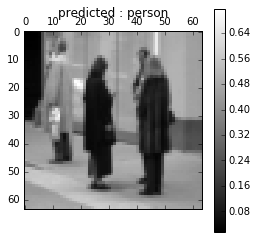

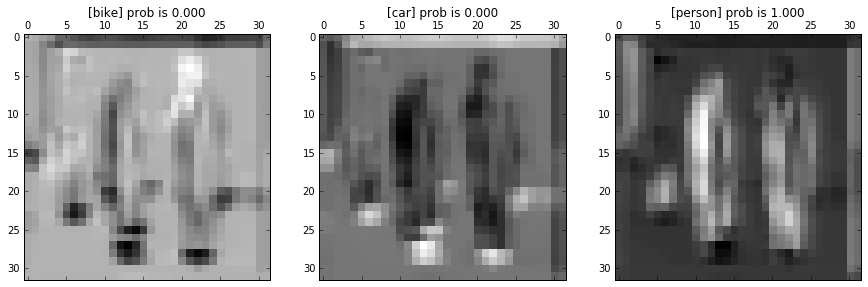

In [33]:
# Observe Nested GAP feature 
rdx = np.random.randint(test_img.shape[0], size=1)

test_x = test_img[rdx,:]
test_y = test_label[rdx:]

test_pred = sess.run(pred,feed_dict={x:test_x,drop_out_prob:1.})
test_out = sess.run(out,feed_dict={x:test_x,drop_out_prob:1.})
test_gap = sess.run(gap,feed_dict={x:test_x,drop_out_prob:1.})
test_w = sess.run(WS['out'])

real_label = ["bike", "car", "person"]
plt.matshow(np.reshape(test_x,[64,64]), cmap=plt.get_cmap('gray'))
plt.title("predicted : " + real_label[test_pred])
plt.colorbar()
plt.show()
    
fig, axs = plt.subplots(1, 3, figsize=(15, 6))    
for i in range(3):
    each_gap_w = test_w[:, i:i+1]
    gap_sum = np.zeros((32, 32))
    for j in range(128):
        gap_sum = gap_sum + each_gap_w[j]*test_gap[0, :, :, j]
    gap_avg = gap_sum / 128
    im = axs[i].matshow(gap_avg, cmap=plt.get_cmap('gray'))
    axs[i].set_title(("[%s] prob is %.3f") % (real_label[i], test_out[0, i]))

plt.draw()